In [1]:
import keras
keras.__version__

'2.6.0'

# 과대적합과 과소적합

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 4장 4절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

----

이전 장에 있던 세 가지 예제인 영화 리뷰 예측, 토픽 분류, 주택 가격 회귀 모두 홀드아웃 데이터에서 모델의 성능이 몇 번의 에포크 후에 최고치에 다다랐다가 감소되기 시작했습니다. 즉, 모델이 금방 훈련 데이터에 과대적합되기 시작합니다. 과대적합은 모든 머신 러닝 문제에서 발생합니다. 머신 러닝을 마스터하려면 과대적합을 다루는 방법을 꼭 배워야 합니다.

머신 러닝의 근본적인 이슈는 최적화와 일반화 사이의 줄다리기입니다. 최적화는 가능한 훈련 데이터에서 최고의 성능을 얻으려고 모델을 조정하는 과정입니다(머신 러닝의 학습). 반면 일반화는 훈련된 모델이 이전에 본 적 없는 데이터에서 얼마나 잘 수행되는지를 의미합니다. 물론 모델을 만드는 목적은 좋은 일반화 성능을 얻는 것입니다. 하지만 일반화 성능을 제어할 방법이 없습니다. 단지 훈련 데이터를 기반으로 모델을 조정할 수만 있습니다.

훈련 초기에 최적화와 일반화는 상호 연관되어 있습니다. 훈련 데이터의 손실이 낮을수록 테스트 데이터의 손실이 낮습니다. 이런 상황이 발생할 때 모델이 과소적합되었다고 말합니다. 모델의 성능이 계속 발전될 여지가 있습니다. 즉, 네트워크가 훈련 데이터에 있는 관련 특성을 모두 학습하지 못했습니다. 하지만 훈련 데이터에 여러 번 반복 학습하고 나면 어느 시점부터 일반화 성능이 더이상 높아지지 않습니다. 검증 세트의 성능이 멈추고 감소되기 시작합니다. 즉, 모델이 과대적합되기 시작합니다. 이는 훈련 데이터에 특화된 패턴을 학습하기 시작했다는 의미입니다. 이 패턴은 새로운 데이터와 관련성이 적어 잘못된 판단을 하게 만듭니다.

모델이 관련성이 없고 좋지 못한 패턴을 훈련 데이터에서 학습하지 못하도록 하려면 가장 좋은 방법은 더 많은 훈련 데이터를 모으는 것입니다. 더 많은 데이터에서 훈련된 모델은 자연히 일반화 성능이 더 뛰어 납니다. 데이터를 더 모으는 것이 불가능할 때 차선책은 모델이 수용할 수 있는 정보의 양을 조절하거나 저장할 수 있는 정보에 제약을 가하는 것입니다. 네트워크가 적은 수의 패턴만을 기억할 수 있다면 최적화 과정에서 가장 중요한 패턴에 집중하게 될 것입니다. 이런 패턴은 더 나은 일반화 성능을 제공할 수 있습니다.

이런 식으로 과대적합을 피하는 처리 과정을 규제라고 합니다. 가장 널리 사용되는 규제 기법을 알아보고 이전 장에서 본 영화 리뷰 분류 모델에 실제로 적용해 성능을 향상시켜 보겠습니다.

노트: 이 노트북에서는 편의상 IMDB 테스트 세트를 검증 세트로 사용합니다.

3장 5절에 있는 코드를 사용해 데이터를 준비합니다:

In [2]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듭니다
    return results

# 훈련 데이터를 벡터로 변환합니다
x_train = vectorize_sequences(train_data)
# 테스트 데이터를 벡터로 변환합니다
x_test = vectorize_sequences(test_data)
# 레이블을 벡터로 변환합니다
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

17473536/17464789 [==============================] - 0s 0us/step


# 과대적합

## 네트워크 크기 축소

과대적합을 막는 가장 단순한 방법은 모델의 크기, 즉 모델에 있는 학습 파라미터의 수를 줄이는 것입니다. 파라미터의 수는 층의 수와 각 층의 유닛 수에 의해 결정됩니다. 딥러닝에서 모델에 있는 학습 파라미터의 수를 종종 모델의 용량이라고 말합니다. 당연하게 파라미터가 많은 모델이 기억 용량이 더 많습니다. 훈련 샘플과 타깃 사이를 딕셔너리와 같은 1:1 매핑으로 완벽하게 학습할 수도 있습니다. 이런 매핑은 일반화 능력이 없습니다. 예를 들어 500,000개의 이진 파라미터가 있는 모델은 MNIST 훈련 세트의 숫자 이미지의 클래스를 쉽게 모두 학습할 수 있습니다. 50,000개의 숫자 이미지 하나마다 10개의 이진 파라미터만 있으면 됩니다. 하지만 이런 모델은 새로운 숫자 샘플을 분류하는 용도로는 쓸모가 없습니다. 항상 유념해야 할 것은 딥러닝 모델은 훈련 데이터에 잘 맞으려는 경향을 가진다는 점입니다. 하지만 진짜 문제는 최적화가 아니고 일반화입니다.

다른 한편으로 네트워크가 기억 용량에 제한이 있다면 이런 매핑을 쉽게 학습하지 못할 것입니다. 따라서 손실을 최소화하기 위해 타깃에 대한 예측 성능을 가진 압축된 표현을 학습해야 합니다. 정확히 이런 표현이 우리의 관심 대상입니다. 동시에 기억해야할 것은 과소적합되지 않도록 충분한 파라미터를 가진 모델을 사용해야 한다는 점입니다. 모델의 기억 용량이 부족해서는 안 됩니다. 너무 많은 용량과 충분하지 않은 용량 사이의 절충점을 찾아야 합니다.

안타깝지만 알맞은 층의 수나 각 층의 유닛 수를 결정할 수 있는 마법 같은 공식은 없습니다. 데이터에 알맞는 모델 크기를 찾으려면 각기 다른 구조를 (당연히 테스트 세트가 아니고 검증 세트에서) 평가해 보아야 합니다. 적절한 모델 크기를 찾는 일반적인 작업 흐름은 비교적 적은 수의 층과 파라미터로 시작합니다. 그다음 검증 손실이 감소되기 시작할 때까지 층이나 유닛의 수를 늘리는 것입니다.

영화 리뷰 분류 모델에 적용해 보죠. 원래 네트워크는 다음과 같습니다:

In [3]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

더 작은 네트워크로 바꾸어 보죠:

In [4]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(6, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(6, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

원본 네트워크와 축소된 네트워크의 검증 손실을 비교해 보죠. 점으로 표현된 것이 작은 네트워크이고 덧셈 기호가 원래 네트워크 입니다(검증 손실이 작은 것이 좋은 모델입니다).

In [5]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 4s 58ms/step - loss: 0.4645 - acc: 0.8246 - val_loss: 0.3621 - val_acc: 0.8631
Epoch 2/20
49/49 [==============================] - 2s 40ms/step - loss: 0.2688 - acc: 0.9081 - val_loss: 0.2865 - val_acc: 0.8896
Epoch 3/20
49/49 [==============================] - 2s 49ms/step - loss: 0.2038 - acc: 0.9280 - val_loss: 0.2804 - val_acc: 0.8894
Epoch 4/20
49/49 [==============================] - 2s 50ms/step - loss: 0.1711 - acc: 0.9380 - val_loss: 0.2894 - val_acc: 0.8852
Epoch 5/20
49/49 [==============================] - 2s 47ms/step - loss: 0.1472 - acc: 0.9490 - val_loss: 0.3076 - val_acc: 0.8801
Epoch 6/20
49/49 [==============================] - 2s 49ms/step - loss: 0.1290 - acc: 0.9561 - val_loss: 0.3497 - val_acc: 0.8710
Epoch 7/20
49/49 [==============================] - 2s 41ms/step - loss: 0.1125 - acc: 0.9620 - val_loss: 0.3758 - val_acc: 0.8670
Epoch 8/20
49/49 [==============================] - 2s 48ms/step - loss: 0.0974 - a

In [7]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 4s 68ms/step - loss: 0.4984 - acc: 0.8068 - val_loss: 0.3866 - val_acc: 0.8736
Epoch 2/20
49/49 [==============================] - 2s 35ms/step - loss: 0.3030 - acc: 0.9034 - val_loss: 0.3078 - val_acc: 0.8868
Epoch 3/20
49/49 [==============================] - 2s 43ms/step - loss: 0.2289 - acc: 0.9246 - val_loss: 0.2950 - val_acc: 0.8837
Epoch 4/20
49/49 [==============================] - 2s 43ms/step - loss: 0.1872 - acc: 0.9382 - val_loss: 0.3026 - val_acc: 0.8770
Epoch 5/20
49/49 [==============================] - 2s 36ms/step - loss: 0.1615 - acc: 0.9459 - val_loss: 0.3025 - val_acc: 0.8788
Epoch 6/20
49/49 [==============================] - 2s 35ms/step - loss: 0.1425 - acc: 0.9521 - val_loss: 0.3045 - val_acc: 0.8808
Epoch 7/20
49/49 [==============================] - 2s 36ms/step - loss: 0.1246 - acc: 0.9594 - val_loss: 0.3280 - val_acc: 0.8768
Epoch 8/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1138 - a

In [8]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

In [9]:
import matplotlib.pyplot as plt

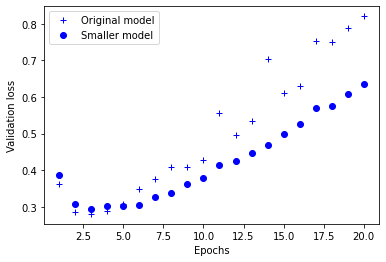

In [10]:
# ‘b+’는 파란색 덧셈 기호을 의미합니다
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

여기서 볼 수 있듯이 작은 네트워크가 기본 네트워크보다 더 나중에 과대적합되기 시작했습니다(네 번째 에포크가 아니라 여섯 번째 에포크에서). 과대적합이 시작되었을 때 성능이 더 천천히 감소되었습니다.

이번에는 문제에 필요한 것보다 훨씬 더 많은 용량을 가진 네트워크를 비교해 보겠습니다:

In [11]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(1024, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(1024, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [12]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 36s 726ms/step - loss: 0.5278 - acc: 0.7950 - val_loss: 0.3519 - val_acc: 0.8509
Epoch 2/20
49/49 [==============================] - 34s 706ms/step - loss: 0.2209 - acc: 0.9136 - val_loss: 0.2814 - val_acc: 0.8903
Epoch 3/20
49/49 [==============================] - 34s 706ms/step - loss: 0.1164 - acc: 0.9610 - val_loss: 1.2751 - val_acc: 0.6854
Epoch 4/20
49/49 [==============================] - 34s 698ms/step - loss: 0.0863 - acc: 0.9780 - val_loss: 0.4052 - val_acc: 0.8838
Epoch 5/20
49/49 [==============================] - 34s 703ms/step - loss: 0.0037 - acc: 0.9993 - val_loss: 0.6633 - val_acc: 0.8762
Epoch 6/20
49/49 [==============================] - 34s 701ms/step - loss: 0.1660 - acc: 0.9869 - val_loss: 0.6553 - val_acc: 0.8618
Epoch 7/20
49/49 [==============================] - 34s 701ms/step - loss: 4.4199e-04 - acc: 1.0000 - val_loss: 0.7057 - val_acc: 0.8818
Epoch 8/20
49/49 [==============================] - 34s 698ms/ste

다음은 더 큰 네트워크가 기본 네트워크에 비해 얼마나 차이나는지를 보여줍니다. 점이 용량이 큰 네트워크의 검증 손실이고 덧셈 기호는 원본 네트워크의 검증 손실입니다.

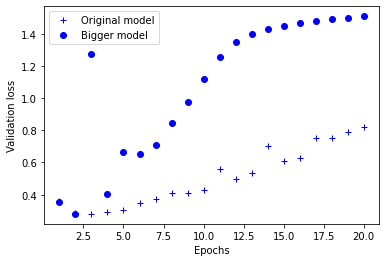

In [13]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

용량이 큰 네트워크는 첫 번째 에포크 이후 거의 바로 과대적합이 시작되어 갈수록 더 심해집니다. 검증 손실도 매우 불안정합니다.

다음은 두 네트워크의 훈련 손실입니다:

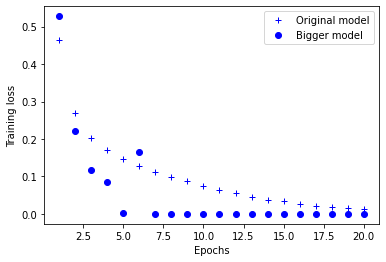

In [14]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

여기서 볼 수 있듯이 용량이 큰 네트워크는 훈련 손실이 매우 빠르게 0에 가까워집니다. 용량이 많은 네트워크일수록 더 빠르게 훈련 데이터를 모델링할 수 있습니다(결국 훈련 손실이 낮아집니다). 하지만 더욱 과대적합에 민감해집니다(결국 훈련과 검증 손실 사이에 큰 차이가 발생합니다).

## 가중치 규제 추가

오캄의 면도날 이론을 알고 있을지 모르겠습니다. 어떤 것에 대한 두 가지의 설명이 있다면 더 적은 가정을 필요하는 간단한 설명이 옳을 것이라는 이론입니다. 이 개념은 신경망으로 학습되는 모델에도 적용됩니다. 어떤 훈련 데이터와 네트워크 구조가 주어졌을 때 데이터를 설명할 수 있는 가중치 값의 집합은 여러 개(여러 개의 모델)입니다. 간단한 모델이 복잡한 모델보다 덜 과대적합될 가능성이 높습니다.

여기에서 간단한 모델은 파라미터 값 분포의 엔트로피가 작은 모델입니다(또는 앞 절에서 본 것처럼 적은 수의 파라미터를 가진 모델입니다). 그러므로 과대적합을 완화시키기 위한 일반적인 방법은 네트워크의 복잡도에 제한을 두어 가중치가 작은 값을 가지도록 강제하는 것입니다. 가중치 값의 분포가 더 균일하게 됩니다. 이를 가중치 규제라고 하고 네트워크의 손실 함수에 큰 가중치에 연관된 비용을 추가합니다. 두 가지 형태의 비용이 있습니다.

* L1 규제 : 가중치의 절대값에 비례하는 비용이 추가됩니다(가중치의 L1 노름).
* L2 규제 : 가중치의 제곱에 비례하는 비용이 추가됩니다(가중치의 L2 노름). L2 규제는 신경망에서 가중치 감쇠라고도 부릅니다. 다른 이름 때문에 혼돈하지 마세요. 가중치 감쇠는 수학적으로 L2 규제와 동일합니다.

케라스에서 가중치 규제 인스턴스를 층의 키워드 매개변수로 전달하여 가중치 규제를 추가할 수 있습니다. 영화 리뷰 분류 네트워크에 L2 가중치 규제를 추가해 보죠:

In [15]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

`l2(0.001)`는 가중치 행렬의 모든 원소를 제곱하고 `0.001`을 곱하여 네트워크의 전체 손실에 더해진다는 의미입니다. 이 페널티 항은 훈련할 때만 추가됩니다. 이 네트워크의 손실은 테스트보다 훈련할 때 더 높을 것입니다.

L2 규제 페널티의 효과를 확인해 보죠:

In [17]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 4s 68ms/step - loss: 0.5092 - acc: 0.8128 - val_loss: 0.3895 - val_acc: 0.8799
Epoch 2/20
49/49 [==============================] - 2s 48ms/step - loss: 0.3229 - acc: 0.9031 - val_loss: 0.3494 - val_acc: 0.8809
Epoch 3/20
49/49 [==============================] - 2s 42ms/step - loss: 0.2724 - acc: 0.9197 - val_loss: 0.3276 - val_acc: 0.8886
Epoch 4/20
49/49 [==============================] - 2s 47ms/step - loss: 0.2489 - acc: 0.9288 - val_loss: 0.3302 - val_acc: 0.8872
Epoch 5/20
49/49 [==============================] - 2s 47ms/step - loss: 0.2365 - acc: 0.9340 - val_loss: 0.3380 - val_acc: 0.8842
Epoch 6/20
49/49 [==============================] - 2s 43ms/step - loss: 0.2255 - acc: 0.9391 - val_loss: 0.3465 - val_acc: 0.8813
Epoch 7/20
49/49 [==============================] - 2s 45ms/step - loss: 0.2164 - acc: 0.9419 - val_loss: 0.3528 - val_acc: 0.8803
Epoch 8/20
49/49 [==============================] - 2s 47ms/step - loss: 0.2102 - a

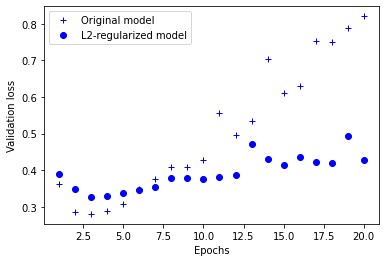

In [18]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

여기서 볼 수 있듯이 두 모델이 동일한 파라미터 수를 가지고 있더라도 L2 규제를 사용한 모델(점)이 기본 모델(덧셈 기호)보다 훨씬 더 과대적합에 잘 견디고 있습니다.

케라스에서 L2 규제 대신에 다음과 같은 가중치 규제 중 하나를 사용할 수 있습니다:

```python
from keras import regularizers

# L1 규제
regularizers.l1(0.001)

# L1과 L2 규제 병행
regularizers.l1_l2(l1=0.001, l2=0.001)
```

### l1(0.0001) 모델과 비교

In [19]:
l1_model = models.Sequential()
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.0001),
                          activation='relu', input_shape=(10000,)))
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.0001),
                          activation='relu'))
l1_model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
l1_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [21]:
l1_model_hist = l1_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 4s 64ms/step - loss: 0.5576 - acc: 0.8182 - val_loss: 0.4252 - val_acc: 0.8820
Epoch 2/20
49/49 [==============================] - 2s 46ms/step - loss: 0.3748 - acc: 0.8956 - val_loss: 0.3769 - val_acc: 0.8870
Epoch 3/20
49/49 [==============================] - 2s 50ms/step - loss: 0.3344 - acc: 0.9056 - val_loss: 0.3631 - val_acc: 0.8882
Epoch 4/20
49/49 [==============================] - 2s 48ms/step - loss: 0.3184 - acc: 0.9107 - val_loss: 0.3623 - val_acc: 0.8872
Epoch 5/20
49/49 [==============================] - 2s 44ms/step - loss: 0.3040 - acc: 0.9171 - val_loss: 0.3737 - val_acc: 0.8807
Epoch 6/20
49/49 [==============================] - 3s 53ms/step - loss: 0.3016 - acc: 0.9173 - val_loss: 0.3670 - val_acc: 0.8846
Epoch 7/20
49/49 [==============================] - 3s 53ms/step - loss: 0.2965 - acc: 0.9179 - val_loss: 0.4089 - val_acc: 0.8708
Epoch 8/20
49/49 [==============================] - 3s 52ms/step - loss: 0.2886 - a

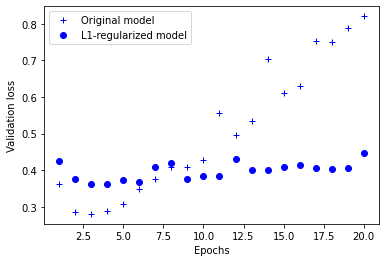

In [22]:
l1_model_val_loss = l1_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l1_model_val_loss, 'bo', label='L1-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### l1_l2(l1=0.0001, l2=0.0001)모델과 비교

In [23]:
l1l2_model = models.Sequential()
l1l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001),
                            activation='relu', input_shape=(10000,)))
l1l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001),
                            activation='relu'))
l1l2_model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
l1l2_model.compile(optimizer='rmsprop',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [25]:
l1l2_model_hist = l1l2_model.fit(x_train, y_train,
                                 epochs=20,
                                 batch_size=512,
                                 validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 6s 108ms/step - loss: 0.5585 - acc: 0.8134 - val_loss: 0.4216 - val_acc: 0.8831
Epoch 2/20
49/49 [==============================] - 3s 52ms/step - loss: 0.3747 - acc: 0.8956 - val_loss: 0.3795 - val_acc: 0.8824
Epoch 3/20
49/49 [==============================] - 2s 51ms/step - loss: 0.3352 - acc: 0.9080 - val_loss: 0.3890 - val_acc: 0.8744
Epoch 4/20
49/49 [==============================] - 2s 49ms/step - loss: 0.3183 - acc: 0.9125 - val_loss: 0.3617 - val_acc: 0.8868
Epoch 5/20
49/49 [==============================] - 2s 51ms/step - loss: 0.3069 - acc: 0.9155 - val_loss: 0.3644 - val_acc: 0.8850
Epoch 6/20
49/49 [==============================] - 2s 51ms/step - loss: 0.2990 - acc: 0.9196 - val_loss: 0.4101 - val_acc: 0.8677
Epoch 7/20
49/49 [==============================] - 3s 52ms/step - loss: 0.2950 - acc: 0.9208 - val_loss: 0.3768 - val_acc: 0.8805
Epoch 8/20
49/49 [==============================] - 2s 48ms/step - loss: 0.2873 - 

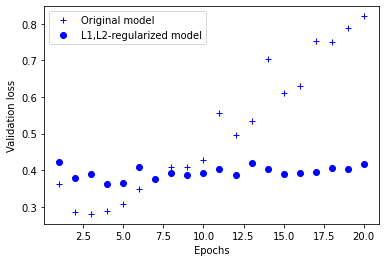

In [26]:
l1l2_model_val_loss = l1l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l1l2_model_val_loss, 'bo', label='L1,L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

## 드롭아웃 추가

드롭아웃은 토론토 대학의 제프리 힌튼과 그의 학생들이 개발했습니다. 신경망을 위해 사용되는 규제 기법 중에서 가장 효과적이고 널리 사용되는 방법 중에 하나입니다. 네트워크의 층에 드롭아웃을 적용하면 훈련하는 동안 무작위로 층의 일부 출력 특성을 제외시킵니다(0으로 만듭니다). 한 층이 정상적으로 훈련하는 동안에는 어떤 입력 샘플에 대해 `[0.2, 0.5, 1.3, 0.8, 1.1]` 벡터를 출력한다고 가정합시다. 드롭아웃을 적용하면 이 벡터의 일부가 무작위로 0으로 바뀝니다. 예를 들면 `[0, 0.5, 1.3, 0, 1.1]`이 됩니다. 드롭아웃 비율은 0이 될 특성의 비율입니다. 보통 0.2에서 0.5 사이로 지정됩니다. 테스트 단계에서는 어떤 유닛도 드롭아웃되지 않습니다. 대신에 층의 출력을 드롭아웃 비율에 비례하여 줄여 줍니다. 훈련할 때보다 더 많은 유닛이 활성화되기 때문입니다.

크기가 `(batch_size, features)`인 한 층의 출력을 담고 있는 넘파이 행렬을 생각해 보겠습니다. 훈련할 때는 이 행렬의 값의 일부가 랜덤하게 0이 됩니다:

```python
# 훈련할 때 유닛의 출력 중 50%를 버립니다
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)
```

테스트할 때는 드롭아웃 비율로 출력을 낮추어 주어야 합니다. 여기에서는 0.5배만큼 스케일을 조정했습니다(앞에서 절반의 유닛을 드롭아웃했으므로):

```python
# 테스트 단계
layer_output *= 0.5
```

훈련 단계에 이 두 연산을 포함시켜 테스트 단계에는 출력을 그대로 두도록 구현할 수 있습니다. 실제로 종종 이런 방식으로 구현합니다:

```python
# 훈련 단계
layer_output *= np.randint(0, high=2, size=layer_output.shape)
# 여기에서 스케일을 낮추는 대신 높입니다![image.png](attachment:image.png)
layer_output /= 0.5
```

이 기법이 이상하고 무계획적으로 보일 수 있습니다. 왜 드롭아웃이 과대적합을 줄이는 데 도움이 될까요? 힌튼은 은행에서 사용하는 부정 방지 메커니즘에서 착안했다고 합니다. 그의 말을 빌리면 “은행에 갔을 때 행원들이 계속 바뀌길래 왜 그런지를 물었습니다. 자신들도 이유는 모르지만 자주 업무가 바뀐다고 했습니다. 나는 은행에서 부정 행위를 하려면 직원들 사이의 유대가 필요하기 때문이라고 판단했습니다. 각 샘플에 대해 뉴런의 일부를 무작위하게 제거하면 뉴런의 부정한 협업을 방지하고 결국 과대적합을 감소시킨다는 것을 깨달았습니다."

핵심 아이디어는 층의 출력 값에 노이즈를 추가하여 중요하지 않은 우연한 패턴(힌튼이 이야기한 부정한 협업)을 깨뜨리는 것입니다. 노이즈가 없다면 네트워크가 이 패턴을 기억하기 시작할 것입니다.

케라스에서는 층의 출력 바로 뒤에 `Dropout` 층을 추가하여 네트워크에 드롭아웃을 적용할 수 있습니다:

```python
model.add(layers.Dropout(0.5))
```

IMDB 네트워크에 두 개의 `Dropout` 층을 추가하고 과대적합을 얼마나 줄여주는지 확인해 보겠습니다:

In [27]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [28]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 5s 67ms/step - loss: 0.5844 - acc: 0.6996 - val_loss: 0.4455 - val_acc: 0.8692
Epoch 2/20
49/49 [==============================] - 2s 49ms/step - loss: 0.4411 - acc: 0.8276 - val_loss: 0.3439 - val_acc: 0.8838
Epoch 3/20
49/49 [==============================] - 2s 50ms/step - loss: 0.3574 - acc: 0.8734 - val_loss: 0.3103 - val_acc: 0.8762
Epoch 4/20
49/49 [==============================] - 2s 48ms/step - loss: 0.3016 - acc: 0.8986 - val_loss: 0.2937 - val_acc: 0.8878
Epoch 5/20
49/49 [==============================] - 2s 49ms/step - loss: 0.2620 - acc: 0.9147 - val_loss: 0.2840 - val_acc: 0.8856
Epoch 6/20
49/49 [==============================] - 2s 47ms/step - loss: 0.2326 - acc: 0.9244 - val_loss: 0.2931 - val_acc: 0.8864
Epoch 7/20
49/49 [==============================] - 2s 47ms/step - loss: 0.2090 - acc: 0.9324 - val_loss: 0.3049 - val_acc: 0.8837
Epoch 8/20
49/49 [==============================] - 2s 49ms/step - loss: 0.1913 - a

결과 그래프를 그려 보죠:

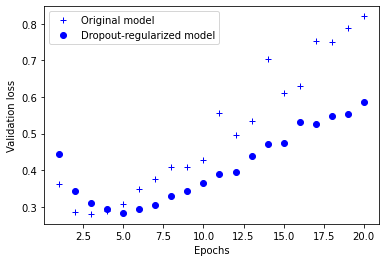

In [29]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

여기에서도 기본 네트워크보다 확실히 향상되었습니다.

정리하면 신경망에서 과대적합을 방지하기 위해 가장 널리 사용하는 방법은 다음과 같습니다.

* 훈련 데이터를 더 모읍니다.
* 네트워크의 용량을 감소시킵니다.
* 가중치 규제를 추가합니다.
* 드롭아웃을 추가합니다